In [18]:
import json
import pickle
import pprint
import dateutil
import datetime
import os
import configparser

import numpy as np
import pandas as pd
import requests
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## constants

In [19]:
cfg_parser = configparser.ConfigParser()
cfg_parser.read('repliers-config.ini')

## paths
CACHE_PATH = 'script-data/'

## api endpoints
LISTINGS_URL = 'https://dev.repliers.io/listings'
LISTINGS_LOCATIONS_URL = 'https://dev.repliers.io/listings/locations'

## request headers
HEADERS = { 'REPLIERS-API-KEY': cfg_parser.get('API_CREDENTIALS', 'key'),
            'content-type': 'application/json' }

## condo details

## menkes
SHERWAY_GARDENS = [{ 'streetName': 'Sherway Gardens', 'streetNumber': 205, 'type': 'sale' }]
GIBSON_SQUARE = [{ 'streetName': 'Yonge', 'streetNumber': 5162, 'type': 'sale' },
                 { 'streetName': 'Yonge', 'streetNumber': 5168, 'type': 'sale' }]
PEARS_ON_THE_AVENUE = [{ 'streetName': 'Avenue', 'streetNumber': 162, 'type': 'sale' },
                       { 'streetName': 'Avenue', 'streetNumber': 170, 'type': 'sale' }]
FABRIK = [{ 'streetName': 'Richmond', 'streetNumber': 435, 'type': 'sale' }]

## tridel
SQ = [{ 'streetName': 'Cameron', 'streetNumber': 38, 'type': 'sale' }]
AQUAVISTA = [{ 'streetName': 'Queens Quay', 'streetNumber': 261, 'type': 'sale' }]
AQUALINA = [{ 'streetName': 'Merchants\' Wharf', 'streetNumber': 15, 'type': 'sale' }]
FRONT_300 = [{ 'streetName': 'Front', 'streetNumber': 300, 'type': 'sale' }]
ALTER = [{ 'streetName': 'Mcgill', 'streetNumber': 89, 'type': 'sale' }]
ERSKINE_101 = [{ 'streetName': 'Erskine', 'streetNumber': 101, 'type': 'sale' }]

## daniels
CINEMA = [{ 'streetName': 'Widmer', 'streetNumber': 21, 'type': 'sale' }]
HIGH_PARK = [{ 'streetName': 'High Park', 'streetNumber': 70, 'type': 'sale' }]
ONE_PARK = [{ 'streetName': 'Sackville', 'streetNumber': 260, 'type': 'sale' }]
BARTHOLOMEW = [{ 'streetName': 'Sackville', 'streetNumber': 200, 'type': 'sale' }]

## great gulf
ONE_BLOOR = [{ 'streetName': 'Bloor', 'streetNumber': 1, 'type': 'sale' }]
ONE_BLOOR_FILTER = [{ 'address.streetDirection': 'E' }]
PACE = [{ 'streetName': 'Dundas', 'streetNumber': 159, 'type': 'sale' }]
PACE_FILTER = [{ 'address.streetDirection': 'E' }]
X2 = [{ 'streetName': 'Charles', 'streetNumber': 101, 'type': 'sale' }]
X2_FILTER = [{ 'address.streetDirection': 'E' }]

## urban capital
RIVER_CITY = [{ 'streetName': 'Trolley', 'streetNumber': 51, 'type': 'sale' }]
SMART_HOUSE = [{ 'streetName': 'Queen', 'streetNumber': 219, 'type': 'sale' }]
SMART_HOUSE_FILTER = [{ 'address.streetDirection': 'W' }]

## streetcar
CORKTOWN = [{ 'streetName': 'King', 'streetNumber': 510, 'type': 'sale' }]
CORKTOWN_FILTER = [{ 'address.streetDirection': 'E' }]
CARNABY = [{ 'streetName': 'Minowan Miikan', 'streetNumber': 20, 'type': 'sale' }]
SYNC = [{ 'streetName': 'Queen', 'streetNumber': 630, 'type': 'sale' }]
SYNC_FILTER = [{ 'address.streetDirection': 'E' }]
TRINITY = [{ 'streetName': 'Eastern', 'streetNumber': 2, 'type': 'sale' },
           { 'streetName': 'Trinity', 'streetNumber': 90, 'type': 'sale' }]
TWENTY = [{ 'streetName': 'Gladstone', 'streetNumber': 20, 'type': 'sale' }]

## concert
KIP = [{ 'streetName': 'Dundas', 'streetNumber': 5365, 'type': 'sale' }]
KIP_FILTER = [{ 'address.streetDirection': 'W' }]
BERCZY = [{ 'streetName': 'Front', 'streetNumber': 55, 'type': 'sale' }]
BERCZY_FILTER = [{ 'address.streetDirection': 'E' }]

## cityscape
GOODERHAM = [{ 'streetName': 'Cherry', 'streetNumber': 390, 'type': 'sale' }]
CLEAR_SPIRIT = [{ 'streetName': 'Distillery', 'streetNumber': 70, 'type': 'sale' }]

## times
CONDOS_500 = [{ 'streetName': 'Sherbourne', 'streetNumber': 500, 'type': 'sale' }]
KEY_WEST = [{ 'streetName': 'Park Lawn', 'streetNumber': 36, 'type': 'sale' }]

## monarch
COUTURE = [{ 'streetName': 'Ted Rogers', 'streetNumber': 28, 'type': 'sale' }]
WATERSCAPES = [{ 'streetName': 'Marine Parade', 'streetNumber': 80, 'type': 'sale' }]

## freed
SIXTY_COLBORNE = [{ 'streetName': 'Colborne', 'streetNumber': 60, 'type': 'sale' }]
ONEFIVEFIVE_REDPATH = [{ 'streetName': 'Redpath', 'streetNumber': 155, 'type': 'sale' }]
FASHION_HOUSE = [{ 'streetName': 'Adelaide', 'streetNumber': 461, 'type': 'sale'},
                 { 'streetName': 'King', 'streetNumber': 560, 'type': 'sale' }]
FASHION_HOUSE_FILTER = [{ 'address.streetDirection': 'W' },
                        { 'address.streetDirection': 'W' }]

## camrost
IMPERIAL_PLAZA = [{ 'streetName': 'St Clair', 'streetNumber': 111, 'type': 'sale' }]
IMPERIAL_PLAZA_FILTER = [{ 'address.streetDirection': 'W' }]
CALIFORNIA = [{ 'streetName': 'Legion', 'streetNumber': 165, 'type': 'sale' }]
YORKVILLE_PLAZA = [{ 'streetName': 'Yorkville', 'streetNumber': 155, 'type': 'sale' }]

## lamb
KING_EAST = [{ 'streetName': 'King', 'streetNumber': 318, 'type': 'sale' }]
KING_EAST_FILTER = [{ 'address.streetDirection': 'E' }]
THEATRE_PARK = [{ 'streetName': 'King', 'streetNumber': 224, 'type': 'sale' }]
THEATRE_PARK_FILTER = [{ 'address.streetDirection': 'W' }]
KING_CHARLOTTE = [{ 'streetName': 'Charlotte', 'streetNumber': 11, 'type': 'sale' }]
BRANT_PARK = [{ 'streetName': 'Brant', 'streetNumber': 39, 'type': 'sale' }]

## metropia
EXHIBIT = [{ 'streetName': 'Bloor', 'streetNumber': 200, 'type': 'sale' }]
EXHIBIT_FILTER = [{ 'address.streetDirection': 'W' }]

## cresford
ONETHOUSAND_BAY = [{ 'streetName': 'St Joseph', 'streetNumber': 57, 'type': 'sale' }]
CASA_II = [{ 'streetName': 'Charles', 'streetNumber': 42, 'type': 'sale' }]
CASA_II_FILTER = [{ 'address.streetDirection': 'E' }]
MERTON = [{ 'streetName': 'Yonge', 'streetNumber': 1815, 'type': 'sale' }]
VOX = [{ 'streetName': 'Wellesley', 'streetNumber': 28, 'type': 'sale' }]
VOX_FILTER = [{ 'address.streetDirection': 'E' }]

## local cache-related params
LISTINGS_CACHE_INSTRUCTIONS = [ { 'params': SHERWAY_GARDENS, 'fname': 'u-listings-sherway.pickle', 'builder': 'menkes' },
                                { 'params': GIBSON_SQUARE, 'fname': 'u-listings-gibson.pickle', 'builder': 'menkes' },
                                { 'params': PEARS_ON_THE_AVENUE, 'fname': 'u-listings-pears.pickle', 'builder': 'menkes' },
                                { 'params': FABRIK, 'fname': 'u-listings-fabrik.pickle', 'builder': 'menkes' },
                               
                                { 'params': SQ, 'fname': 'u-listings-gibson.pickle', 'builder': 'tridel' },
                                { 'params': AQUAVISTA, 'fname': 'u-listings-aquavista.pickle', 'builder': 'tridel' },
                                { 'params': AQUALINA, 'fname': 'u-listings-aqualina.pickle', 'builder': 'tridel' },
                                { 'params': FRONT_300, 'fname': 'u-listings-300-front.pickle', 'builder': 'tridel' },
                                { 'params': ALTER, 'fname': 'u-listings-alter.pickle', 'builder': 'tridel' },
                                { 'params': ERSKINE_101, 'fname': 'u-listings-101-erskine.pickle', 'builder': 'tridel' },
                              
                                { 'params': CINEMA, 'fname': 'u-listings-cinema.pickle', 'builder': 'daniels' },
                                { 'params': HIGH_PARK, 'fname': 'u-listings-high-park.pickle', 'builder': 'daniels' },
                                { 'params': ONE_PARK, 'fname': 'u-listings-one-park.pickle', 'builder': 'daniels' },
                                { 'params': BARTHOLOMEW, 'fname': 'u-listings-bartholomew.pickle', 'builder': 'daniels' },
                              
                                { 'params': ONE_BLOOR, 'filters': ONE_BLOOR_FILTER, 'fname': 'u-listings-one-bloor.pickle', 'builder': 'great-gulf' },
                                { 'params': PACE, 'filters': PACE_FILTER, 'fname': 'u-listings-pace.pickle', 'builder': 'great-gulf' },
                                { 'params': X2, 'filters': X2_FILTER, 'fname': 'u-listings-x2.pickle', 'builder': 'great-gulf' },
                              
                                { 'params': RIVER_CITY, 'fname': 'u-listings-river-city.pickle', 'builder': 'urban-capital' },
                                { 'params': SMART_HOUSE, 'filters': SMART_HOUSE_FILTER, 'fname': 'u-listings-smart-house.pickle', 'builder': 'urban-capital' },
                              
                                { 'params': CORKTOWN, 'filters': CORKTOWN_FILTER, 'fname': 'u-listings-corktown.pickle', 'builder': 'streetcar'},
                                { 'params': CARNABY, 'fname': 'u-listings-carnaby.pickle', 'builder': 'streetcar'},
                                { 'params': SYNC, 'filters': SYNC_FILTER, 'fname': 'u-listings-sync.pickle', 'builder': 'streetcar'},
                                { 'params': TRINITY, 'fname': 'u-listings-trinity.pickle', 'builder': 'streetcar'},
                                { 'params': TWENTY, 'fname': 'u-listings-twenty.pickle', 'builder': 'streetcar'},
                              
                                { 'params': KIP, 'filters': KIP_FILTER, 'fname': 'u-listings-kip.pickle', 'builder': 'concert'},
                                { 'params': BERCZY, 'filters': BERCZY_FILTER, 'fname': 'u-listings-berczy.pickle', 'builder': 'concert'},
                              
                                { 'params': GOODERHAM, 'fname': 'u-listings-gooderham.pickle', 'builder': 'cityscape' },
                                { 'params': CLEAR_SPIRIT, 'fname': 'u-listings-clear-spirit.pickle', 'builder': 'cityscape' },
                              
                                { 'params': CONDOS_500, 'fname': 'u-listings-500-condos.pickle', 'builder': 'times' },
                                { 'params': KEY_WEST, 'fname': 'u-listings-key-west.pickle', 'builder': 'times' },
                              
                                { 'params': COUTURE, 'fname': 'u-listings-couture.pickle', 'builder': 'monarch' },
                                { 'params': WATERSCAPES, 'fname': 'u-listings-waterscapes.pickle', 'builder': 'monarch' },
                              
                                { 'params': SIXTY_COLBORNE, 'fname': 'u-listings-60-colborne.pickle', 'builder': 'freed' },
                                { 'params': ONEFIVEFIVE_REDPATH, 'fname': 'u-listings-155-redpath.pickle', 'builder': 'freed' },
                                { 'params': FASHION_HOUSE, 'filters': FASHION_HOUSE_FILTER, 'fname': 'u-listings-fashion-house.pickle', 'builder': 'freed' },
                              
                                { 'params': IMPERIAL_PLAZA, 'filters': IMPERIAL_PLAZA_FILTER, 'fname': 'u-listings-imperial-plaza.pickle', 'builder': 'camrost' },
                                { 'params': CALIFORNIA, 'fname': 'u-listings-california.pickle', 'builder': 'camrost' },
                                { 'params': YORKVILLE_PLAZA, 'fname': 'u-listings-yorkville-plaza.pickle', 'builder': 'camrost' },
                               
                                { 'params': KING_EAST, 'filters': KING_EAST_FILTER, 'fname': 'u-listings-king-east.pickle', 'builder': 'lamb' },
                                { 'params': THEATRE_PARK, 'filters': THEATRE_PARK_FILTER, 'fname': 'u-listings-theatre-park.pickle', 'builder': 'lamb' },
                                { 'params': KING_CHARLOTTE, 'fname': 'u-listings-king-charlotte.pickle', 'builder': 'lamb' },
                                { 'params': BRANT_PARK, 'fname': 'u-listings-brant-park.pickle', 'builder': 'lamb' },
                               
                                #{ 'params': EXHIBIT, 'filters': EXHIBIT_FILTER, 'fname': 'u-listings-exhibit.pickle', 'builder': 'metropia' },

                                { 'params': ONETHOUSAND_BAY, 'fname': 'u-listings-1000-bay.pickle', 'builder': 'cresford' },
                                { 'params': CASA_II, 'filters': CASA_II_FILTER, 'fname': 'u-listings-casa-ii.pickle', 'builder': 'cresford' },
                                { 'params': MERTON, 'fname': 'u-listings-merton.pickle', 'builder': 'cresford' },
                                { 'params': VOX, 'filters': VOX_FILTER, 'fname': 'u-listings-vox.pickle', 'builder': 'cresford' }
                              ]

RENT_CACHE_INSTRUCTIONS = []
    
for ins in LISTINGS_CACHE_INSTRUCTIONS:
    ins = ins.copy()
    ins['fname'] = 'rent-%s' % ins['fname']
    RENT_CACHE_INSTRUCTIONS.append(ins)

## i/o & convenience functions

In [20]:
def save(obj, fname='cache.pickle'):
    pickle.dump(obj, open('%s/%s' % (CACHE_PATH, fname), "wb"))

def load(fname='cache.pickle'):
    return pickle.load(open('%s/%s' % (CACHE_PATH, fname), "rb"))

def print_nicely(txt, use_pprint=False):
    if use_pprint:
        pprint.pprint(txt)
    else:
        print(json.dumps(txt, indent=4))
        
def deep_lookup(d, k):
    for tok in k.split('.'):
        d = d[tok]
    return d

## raw data pipepline

In [21]:
def extract_locations():
    req = requests.get(LISTINGS_LOCATIONS_URL, headers=HEADERS)
    return req

def extract_listings(city='Toronto', status='U', mode=None, params={}, filters={}):
    if city is not None:
        params['city'] = city
        
    if status is not None:
        params['status'] = status
        
    if mode is not None:
        params['type'] = mode
        
    req = requests.get(LISTINGS_URL, headers=HEADERS, params=params)
    content = json.loads(req.text)
    
    if filters:
        for filter_key, filter_value in filters.items():
            if isinstance(filter_value, list):
                content['listings'] = [ l for l in content['listings'] if deep_lookup(l, filter_key) in filter_value ]
            else:
                content['listings'] = [ l for l in content['listings'] if deep_lookup(l, filter_key) == filter_value ]                
    
    return content

def _raw_listings_etl(city='Toronto', status='U', mode=None, params_list=[], filters_list=[], stash_fname='cache.pickle'):
    if not params_list:
        return False
    
    ## extract
    if filters_list:
        es = [ extract_listings(city=city, status=status, mode=mode, params=params, filters=filters_list[i]) for (i, params) in enumerate(params_list) ]
    else:
        es = [ extract_listings(city=city, status=status, mode=mode, params=params) for params in params_list ]
        
    ## transform
    t = es[0]
    
    for e in es[1:]:
        t['listings'] = t['listings'] + e['listings']
        
    ## load
    save(t, fname=stash_fname)
    
    return True

def raw_listings_etl(city='Toronto', status='U', mode=None, cache_instructions=[]):
    for instruction in cache_instructions:
        params = instruction['params']
        filters = instruction['filters'] if 'filters' in instruction else []
        stash_fname = instruction['fname']
        
        if (len(filters) > 0) and (len(filters) != len(params)):
            raise ValueError('Received %s params, but %s filters' % (len(params), len(filters)))
        
        _raw_listings_etl(city=city, status=status, mode=mode, params_list=params, filters_list=filters, stash_fname=stash_fname)

## summary data pipeline

In [22]:
def transform_listings_to_summary(listings=[], builder=None):
    rows = []
    
    for listing in listings:
        if listing['lastStatus'] is None:
            continue
            
        if listing['lastStatus'] in ['Exp', 'Ter', 'Sus']:
            continue
            
        if listing['soldDate'] == '0000-00-00 00:00:00':
            continue

        ## address
        street_number = listing['address']['streetNumber']
        street_name = listing['address']['streetName']
        street_suffix = listing['address']['streetSuffix']
        street_direction = listing['address']['streetDirection']
        
        ## dates
        list_date = dateutil.parser.parse(listing['listDate'])
        sold_date = dateutil.parser.parse(listing['soldDate'])
        dom = int(listing['daysOnMarket'])
        computed_dom = (sold_date - list_date).days

        ## prices
        list_price = float(listing['listPrice'])
        sold_price = float(listing['soldPrice'])
        sold_list_difference = sold_price - list_price

        ## meta
        if listing['taxes']['annualAmount'] == '':
            taxes = -1
        else:
            taxes = float(listing['taxes']['annualAmount'])
            
        if listing['details']['sqft'] == '':
            sqft = -1
        else:
            sqft = int(listing['details']['sqft'].split('-')[1])
        
        ## bedrooms
        n_bedrooms = listing['details']['numBedrooms']
        n_bedrooms = 0 if (n_bedrooms is None) or (n_bedrooms == '') else float(n_bedrooms)
        
        n_bedrooms_plus = listing['details']['numBedroomsPlus']
        n_bedrooms_plus = 0 if (n_bedrooms_plus is None) or (n_bedrooms_plus == '') else (float(n_bedrooms_plus) / 2)
        
        n_bedrooms = n_bedrooms + n_bedrooms_plus

        ## bathrooms
        n_bathrooms = listing['details']['numBathrooms']
        n_bathrooms = 0 if (n_bathrooms is None) or (n_bathrooms == '') else float(n_bathrooms)
        
        n_bathrooms_plus = listing['details']['numBathroomsPlus']
        n_bathrooms_plus = 0 if (n_bathrooms_plus is None) or (n_bathrooms_plus == '') else (float(n_bathrooms_plus) / 2)
        
        n_bathrooms = n_bathrooms + n_bathrooms_plus

        ## add row
        rows.append({ 'street_number': street_number, 
                      'street_name': street_name, 
                      'street_suffix': street_suffix,
                      'street_direction': street_direction,
                      'builder': builder,
                      'list_date': list_date,
                      'sold_date': sold_date,
                      'dom': dom,
                      'computed_dom': computed_dom,
                      'list_price': list_price, 
                      'sold_price': sold_price, 
                      'sold_list_difference': sold_list_difference,
                      'taxes': taxes, 
                      'n_bedrooms': n_bedrooms, 
                      'n_bathrooms': n_bathrooms,
                      'sqft': sqft })

    return pd.DataFrame(rows)
    
def _summary_listings_etl(stash_fname='cache.pickle', builder=None):
    cached_listings = load(fname=stash_fname)
    return transform_listings_to_summary(listings=cached_listings['listings'], builder=builder)

def summary_listings_etl(cache_instructions=[]):
    ## extract
    es = [ _summary_listings_etl(stash_fname=ins['fname'], builder=ins['builder']) for ins in cache_instructions ]
    
    ## transform        
    t = pd.concat(es)
    
    return t.reset_index(drop=True)

## scripting

In [23]:
RELOAD_SOLD_CACHE = False
RELOAD_RENT_CACHE = False
SAVE_CSV = False

if RELOAD_SOLD_CACHE:
    raw_listings_etl(cache_instructions=LISTINGS_CACHE_INSTRUCTIONS)
    
if RELOAD_RENT_CACHE:
    raw_listings_etl(cache_instructions=RENT_CACHE_INSTRUCTIONS, mode='lease')
    
if SAVE_CSV:
    df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)
    df = df.sort_values('sold_date')
    columns_to_save = [ 'builder',
                        'street_number',
                        'street_name', 
                        'street_suffix',
                        'street_direction',
                        'list_date',
                        'sold_date',
                        'dom',
                        'list_price', 
                        'sold_price', 
                        'sold_list_difference', 
                        'taxes', 
                        'n_bedrooms', 
                        'n_bathrooms' ]
    df.to_csv('condo-sales-190119.csv', columns=columns_to_save, index=False, header=True, date_format='%Y-%m-%d')

In [33]:
sale_df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)
rent_df = summary_listings_etl(RENT_CACHE_INSTRUCTIONS)

sale_df['$_per_sqft'] = sale_df['sold_price'] / sale_df['sqft']
rent_df['$_per_sqft'] = rent_df['sold_price'] / rent_df['sqft']


#for group_header, property_df in rent_df.groupby(['street_number', 'street_name', 'street_suffix', 'street_direction', 'n_bedrooms', 'n_bathrooms']):
#    property_df.agg({'sold_price': 'mean'})
rent_df.groupby(['street_number', 'street_name', 'street_suffix', 'street_direction', 'n_bedrooms', 'n_bathrooms']).agg({'sold_price': 'mean'})

sold_price
street_number street_name   street_suffix street_direction n_bedrooms n_bathrooms             
1             Bloor         St            E                0.0        0.0           250.000000
                                                           1.0        1.0          2487.173913
                                                           1.5        1.0          2503.928571
                                                                      2.0          3051.666667
                                                           2.0        2.0          3638.913043
                                                                      3.0          4350.000000
                                                           2.5        2.0          4121.428571
                                                                      3.0          4777.600000
                                                           3.0        3.0          6500.000000
101           Charles       St            E                0.0        1.0          1865.000000
                                                           1.0        1.0          2229.166667
                                                                      4.0          2200.000000
                                                           1.5        1.0          2538.750000
                                                                      2.0          2300.000000
                                                           2.0        2.0          3105.000000
                                                           3.0        2.0          3200.000000
              Erskine       Ave                            0.0        1.0          1950.000000
                                                           1.0        1.0          1933.333333
                                                           1.5        1.0          2175.000000
                                                                      2.0          2400.000000
                                                           2.0        2.0          2742.857143
                                                                      3.0          3150.000000
11            Charlotte     St                             1.0        1.0          2044.285714
                                                           1.5        1.0          2325.000000
                                                           2.0        1.0          3100.000000
                                                                      2.0          3503.846154
                                                           3.0        2.0          3883.333333
111           St Clair      Ave           W                1.0        1.0          1911.666667
                                                                      2.0          2890.000000
                                                                      3.0          2400.000000
...                                                                                        ...
60            Colborne      St                             2.5        1.0          3200.000000
                                                                      2.0          3295.000000
630           Queen         St            E                1.0        1.0          1712.083333
                                                           1.5        1.0          2175.000000
                                                           2.0        1.0          2175.000000
                                                                      2.0          2700.000000
70            Distillery    Lane                           1.0        1.0          2091.216216
                                                                      2.0          2550.000000
                                                           1.5        1.0          2187.857143
                                                           2.0        2.0          3163.666667

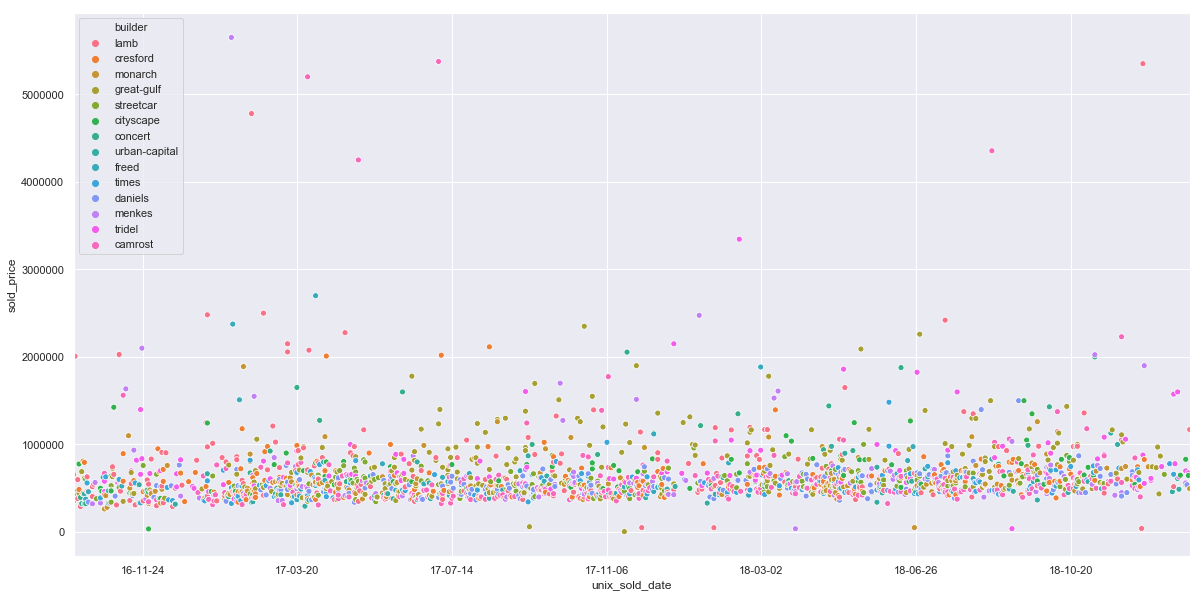

In [24]:
df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)
df = df.sort_values('sold_date')

builders = [ ins['builder'] for ins in LISTINGS_CACHE_INSTRUCTIONS ]
builders = list(set(builders))

#df = df[(df['n_bedrooms'] == 1) & (df['n_bedrooms'] == 2)]
#df = df[df['n_bedrooms'] == 1]

df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df = df.set_index('sold_date', drop=False)

df['unix_sold_date'] = df['sold_date'].astype(np.int64)
df['mean_sold_price'] = df['sold_price'].rolling(25).mean()

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.scatterplot(ax=ax, x="unix_sold_date", y="sold_price", hue='builder', data=df)
#ax = sns.lineplot(ax=ax, x="sold_date", y="mean_sold_price", data=df)
#ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", scatter=False, data=df[df['builder'] == 'tridel'])

#for builder in builders:
#    ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", scatter=True, data=df[df['builder'] == builder])

ax.set_xlim(df['unix_sold_date'].min(), df['unix_sold_date'].max())

labels = ax.get_xticks()
labels = [ int(l / 1000000000) for l in labels ]
#labels = [ item.get_text() for item in ax.get_xticks() ]
labels = [ datetime.datetime.utcfromtimestamp(ts).strftime('%y-%m-%d') for ts in labels ]
_ = ax.set_xticklabels(labels)

#print(df['sold_price'].rolling(3).mean())
#print(df['sold_price'])

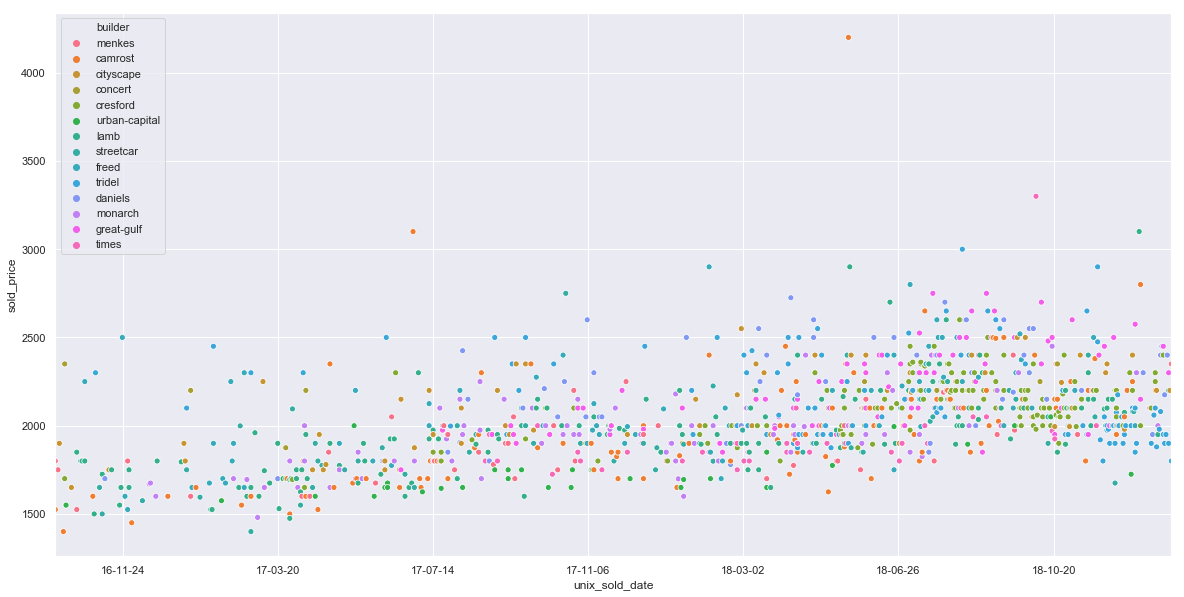

In [26]:
df = summary_listings_etl(RENT_CACHE_INSTRUCTIONS)
df = df.sort_values('sold_date')

builders = [ ins['builder'] for ins in RENT_CACHE_INSTRUCTIONS ]
builders = list(set(builders))

#df = df[(df['n_bedrooms'] == 1) & (df['n_bedrooms'] == 2)]
df = df[df['n_bedrooms'] == 1]

df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df = df.set_index('sold_date', drop=False)

df['unix_sold_date'] = df['sold_date'].astype(np.int64)
df['mean_sold_price'] = df['sold_price'].rolling(25).mean()

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.scatterplot(ax=ax, x="unix_sold_date", y="sold_price", hue='builder', data=df)
#ax = sns.lineplot(ax=ax, x="sold_date", y="mean_sold_price", data=df)
#ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", scatter=False, data=df[df['builder'] == 'tridel'])

#for builder in builders:
#    ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", scatter=True, data=df[df['builder'] == builder])

ax.set_xlim(df['unix_sold_date'].min(), df['unix_sold_date'].max())

labels = ax.get_xticks()
labels = [ int(l / 1000000000) for l in labels ]
#labels = [ item.get_text() for item in ax.get_xticks() ]
labels = [ datetime.datetime.utcfromtimestamp(ts).strftime('%y-%m-%d') for ts in labels ]
_ = ax.set_xticklabels(labels)

#print(df['sold_price'].rolling(3).mean())
#print(df['sold_price'])

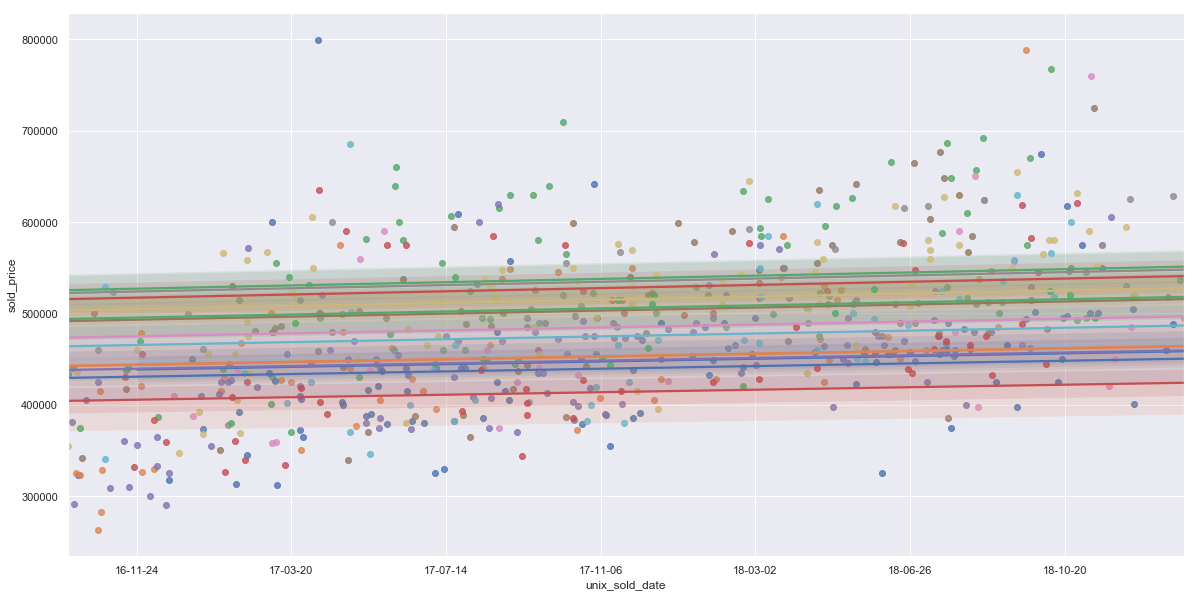

In [51]:
df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)
df = df.sort_values('sold_date')

builders = [ ins['builder'] for ins in LISTINGS_CACHE_INSTRUCTIONS ]
builders = list(set(builders))

#df = df[(df['n_bedrooms'] == 1) & (df['n_bedrooms'] == 2)]
df = df[df['n_bedrooms'] == 1]

df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df = df.set_index('sold_date', drop=False)
df['unix_sold_date'] = df['sold_date'].astype(np.int64)

sns.set()
fig, ax = plt.subplots(figsize=(20, 10))

for builder in builders:
    ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", order=True, scatter=True, data=df[df['builder'] == builder])

ax.set_xlim(df['unix_sold_date'].min(), df['unix_sold_date'].max())

labels = ax.get_xticks()
labels = [ int(l / 1000000000) for l in labels ]
labels = [ datetime.datetime.utcfromtimestamp(ts).strftime('%y-%m-%d') for ts in labels ]
_ = ax.set_xticklabels(labels)

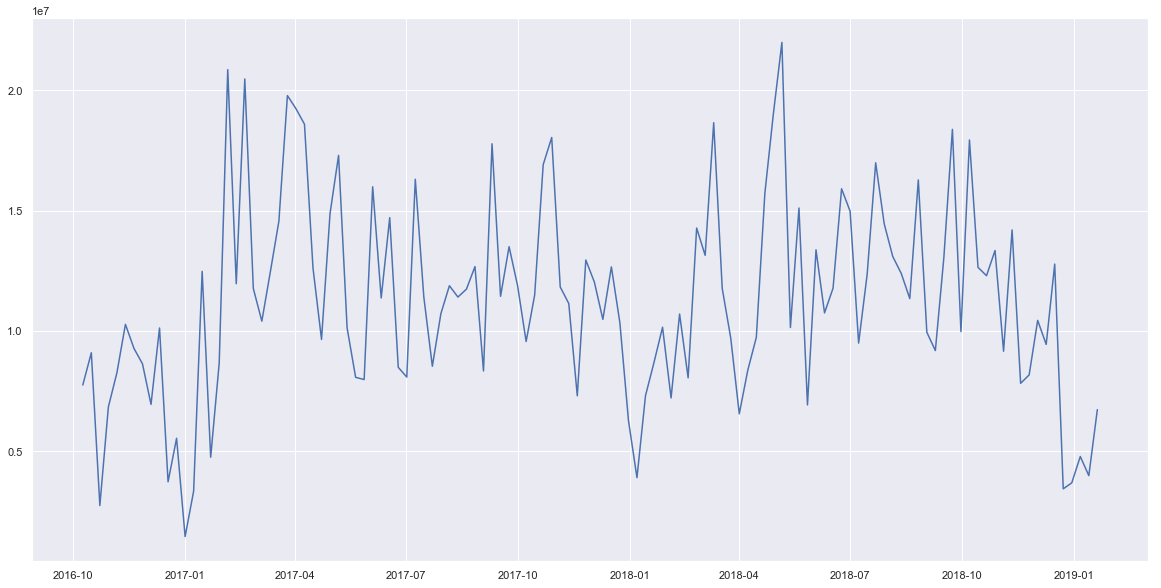

In [14]:
df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)
df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df = df.set_index('sold_date', drop=False)
monthly_sales = df['sold_price'].resample('W').sum()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(ax=ax, data=monthly_sales)

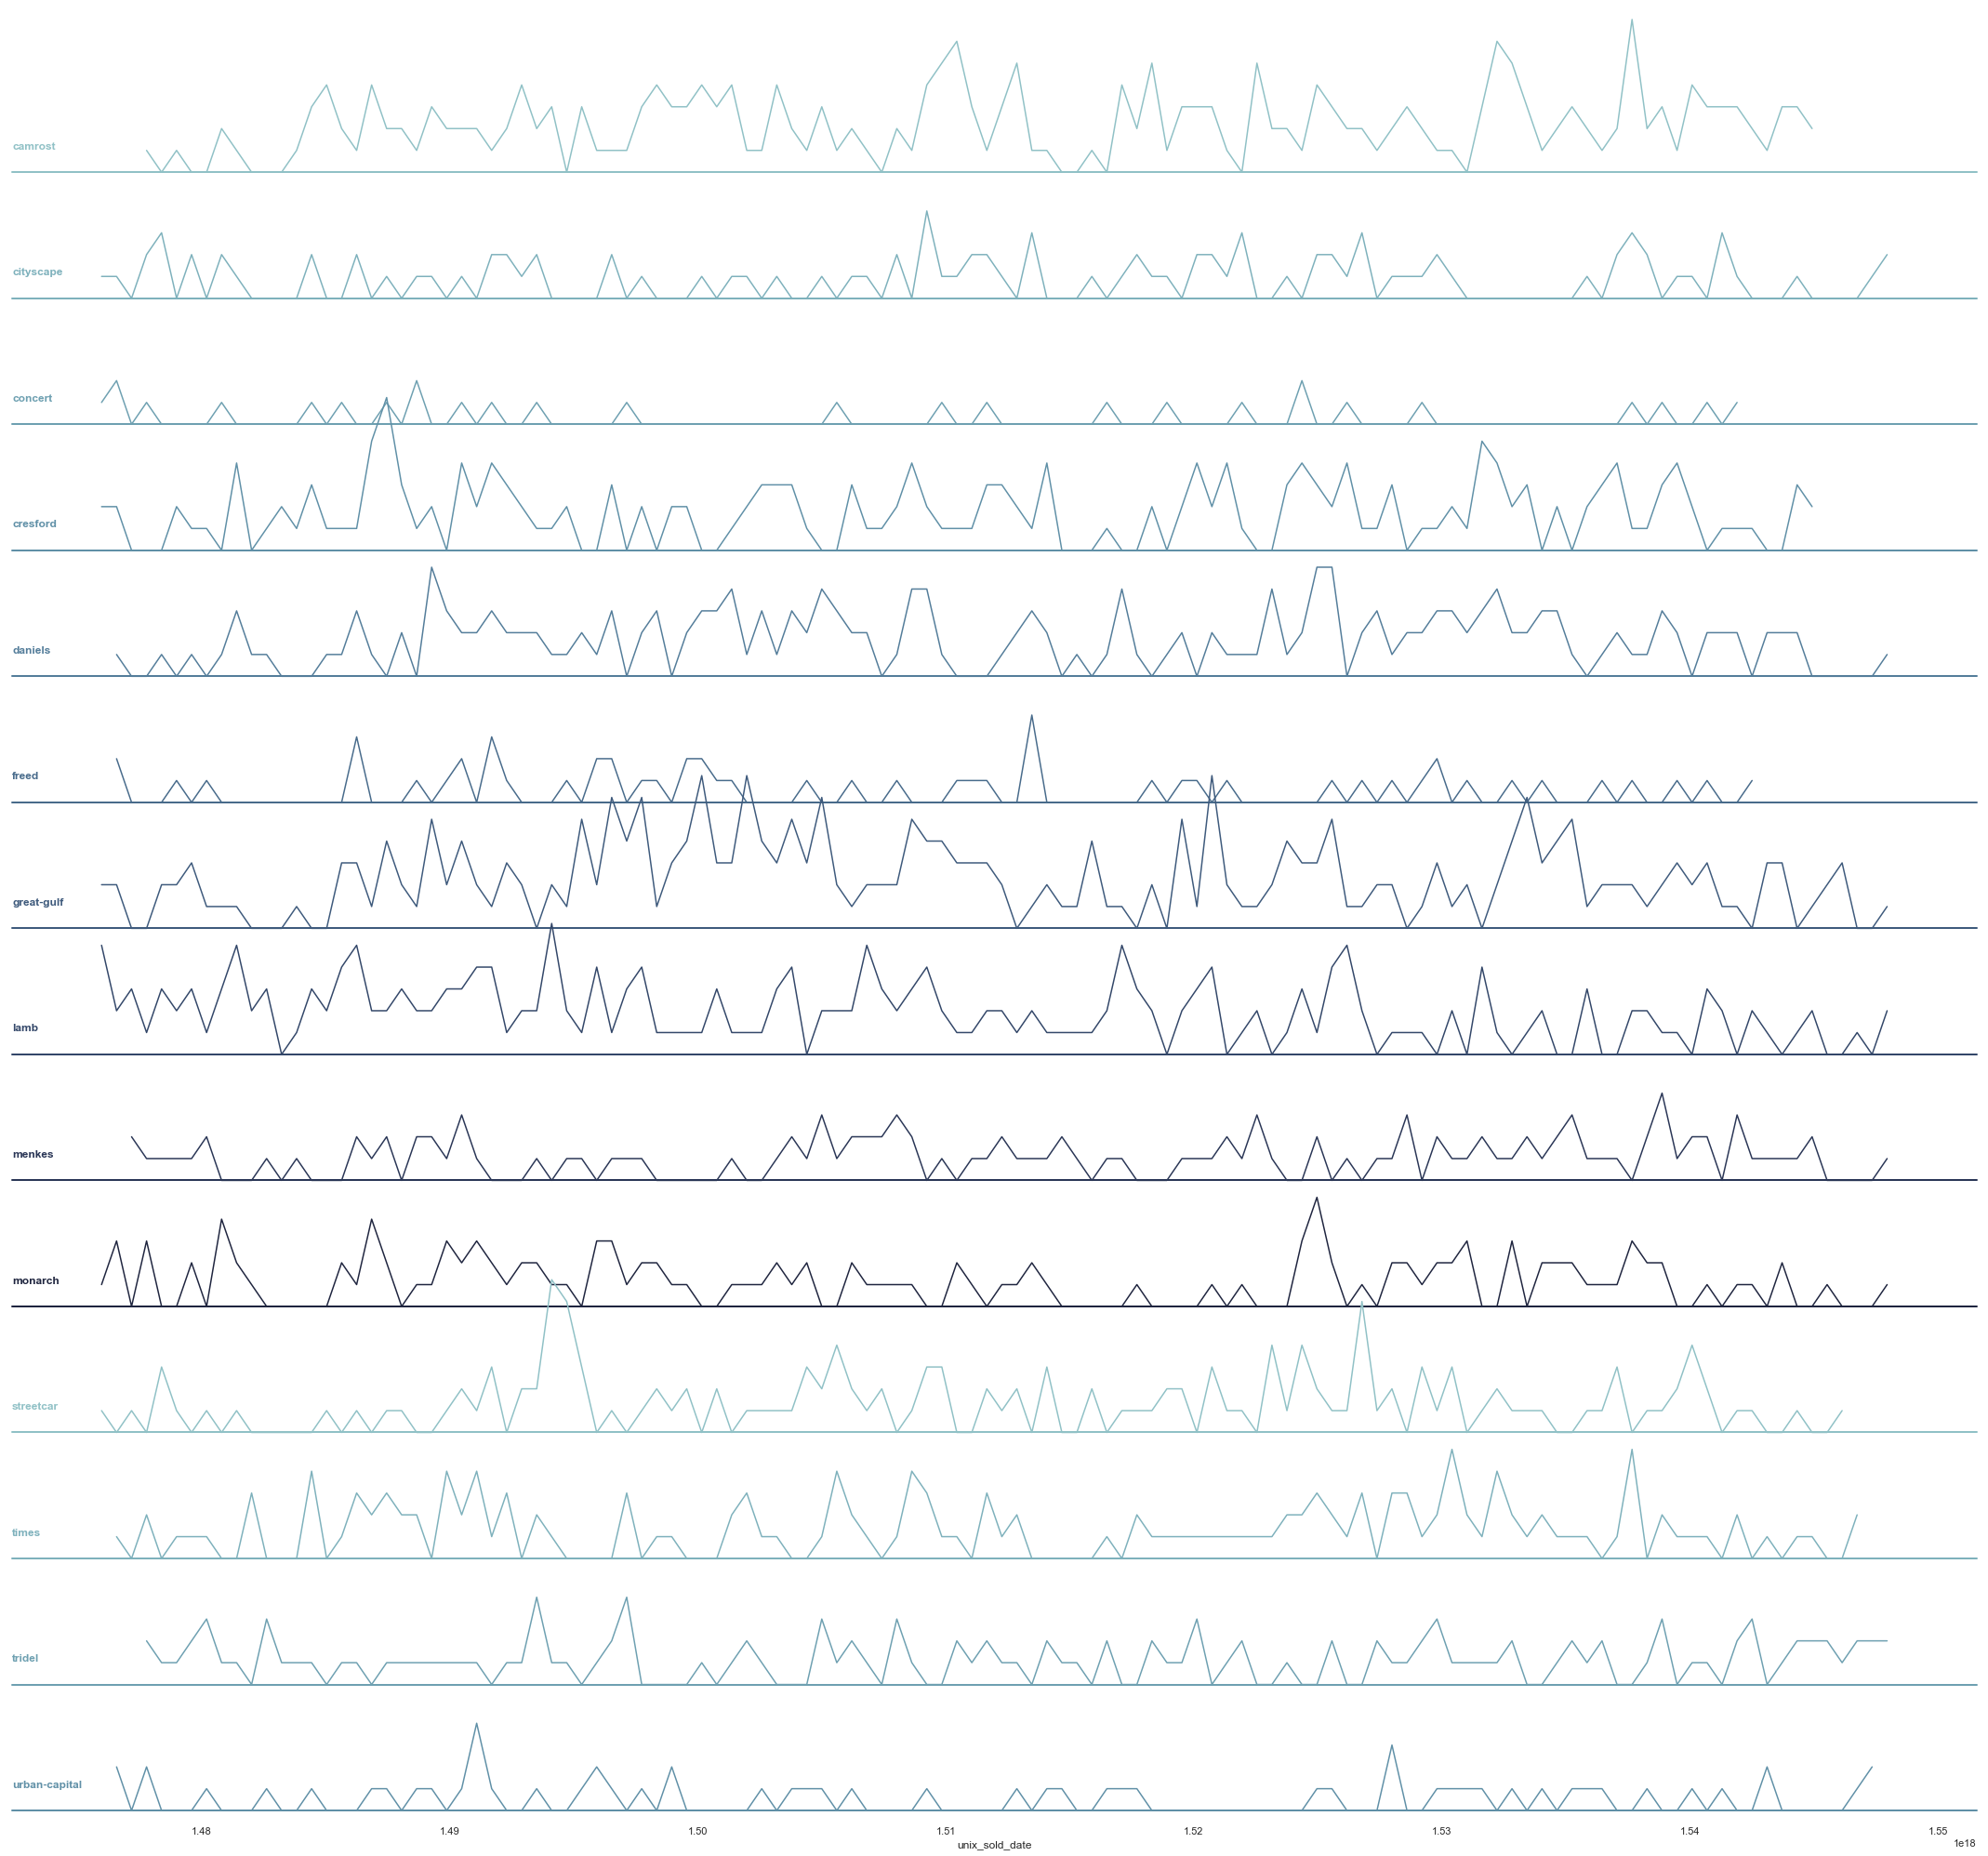

In [41]:
df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)

df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df['tally'] = 1
df = df.set_index('sold_date', drop=False)

df = df.groupby('builder').resample('W').sum().reset_index()
df = df.set_index('sold_date', drop=False)

df['unix_sold_date'] = df['sold_date'].astype(np.int64)

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="builder", hue="builder", aspect=15, height=2, palette=pal)

# Draw the densities in a few steps
g.map(sns.lineplot, "unix_sold_date", "tally", clip_on=False, alpha=1, lw=1.5)
#g.map(sns.lineplot, "unix_sold_date", "sold_price", clip_on=False, color="b", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "unix_sold_date")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

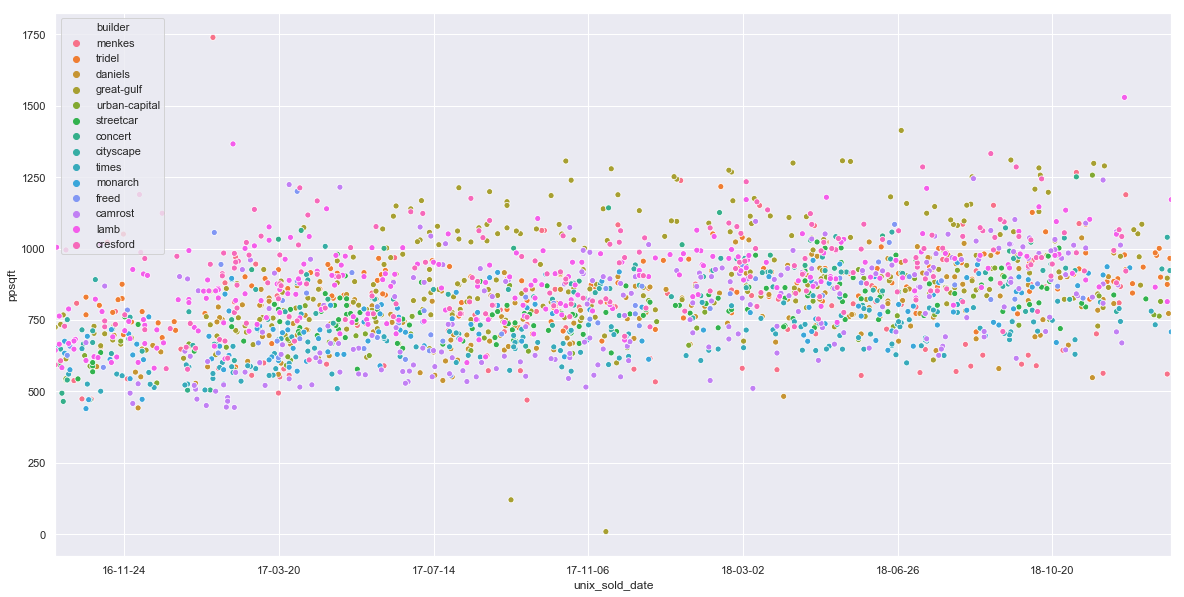

In [70]:
#load('u-listings-1000-bay.pickle')
df = summary_listings_etl(LISTINGS_CACHE_INSTRUCTIONS)
df = df[df['sqft'] != -1]
df['ppsqft'] = df['sold_price'] / df['sqft']

builders = [ ins['builder'] for ins in LISTINGS_CACHE_INSTRUCTIONS ]
builders = list(set(builders))

df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df = df.set_index('sold_date', drop=False)

df['unix_sold_date'] = df['sold_date'].astype(np.int64)
df['mean_sold_price'] = df['sold_price'].rolling(25).mean()

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.scatterplot(ax=ax, x="unix_sold_date", y="ppsqft", hue='builder', data=df)

ax.set_xlim(df['unix_sold_date'].min(), df['unix_sold_date'].max())

labels = ax.get_xticks()
labels = [ int(l / 1000000000) for l in labels ]
labels = [ datetime.datetime.utcfromtimestamp(ts).strftime('%y-%m-%d') for ts in labels ]
_ = ax.set_xticklabels(labels)